# Sunblock Review EDA

수집한 선크림 리뷰 텍스트 데이터를 다양한 각도에서 탐색하는 노트북입니다.

## 목차
1. 환경 설정 및 데이터 로딩
2. 기초 통계 (평점, 리뷰 길이, 상위 제품)
3. LLM 추출 데이터 탐색 (Aspect, Polarity)
4. 리포트 시각화 (Bucket별, Context별 분석)

In [1]:
# 필요 라이브러리 설치
import sys
!{sys.executable} -m pip install -q matplotlib seaborn pandas pyarrow

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
print("환경 설정 완료")

환경 설정 완료


---
## 1. 데이터 로딩

In [3]:
# 리뷰 데이터 로딩
reviews_path = '../data/processed/reviews_clean.parquet'
reviews = pd.read_parquet(reviews_path)
print(f"리뷰 데이터: {reviews.shape[0]:,}건, {reviews.shape[1]}개 컬럼")

# 제품 정보 병합
products_path = '../data/raw/products_20251221.jsonl'
products = pd.read_json(products_path, lines=True)
reviews['goods_no'] = reviews['goods_no'].astype(str)
products['goods_no'] = products['goods_no'].astype(str)
reviews = reviews.merge(products[['goods_no', 'product_name', 'brand']], on='goods_no', how='left')

# LLM 분석 결과 로딩
master_path = '../data/analysis/step4_master_join.parquet'
master = pd.read_parquet(master_path)
print(f"LLM 분석 데이터: {master.shape[0]:,}건, {master.shape[1]}개 컬럼")

# 피벗 테이블 로딩
polarity_overall = pd.read_parquet('../data/analysis/pivot_aspect_polarity_overall.parquet')
polarity_bucket = pd.read_parquet('../data/analysis/pivot_aspect_polarity_by_bucket.parquet')
context_unmet = pd.read_parquet('../data/analysis/pivot_context_aspect_unmet.parquet')
season_unmet = pd.read_parquet('../data/analysis/pivot_season_aspect_unmet.parquet')

print("\n모든 데이터 로딩 완료")

리뷰 데이터: 10,639건, 21개 컬럼
LLM 분석 데이터: 7,471건, 25개 컬럼

모든 데이터 로딩 완료


---
## 2. 기초 통계

In [4]:
# 기본 정보
print("=== 리뷰 데이터 컬럼 ===")
print(reviews.columns.tolist())
print("\n=== 결측치 ===")
print(reviews.isnull().sum()[reviews.isnull().sum() > 0])

=== 리뷰 데이터 컬럼 ===
['review_id', 'goods_no', 'product_id', 'rating', 'review_date', 'skin_type_raw', 'skin_tone_raw', 'skin_trouble_raw', 'review_text', 'helpful_count', 'has_images', 'image_count', 'review_type', 'is_trial', 'is_low_info', 'source', 'sort_sources', 'primary_sort', 'sort_count', 'sort_sources_all', 'sort_sources_str', 'product_name', 'brand']

=== 결측치 ===
skin_type_raw       6124
skin_tone_raw       6325
sort_sources_all    7372
dtype: int64


/var/folders/j4/kv6kpgcj0fj1xv3n1l2jmpch0000gn/T/ipykernel_57754/1788736134.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=reviews, palette='viridis', ax=ax)


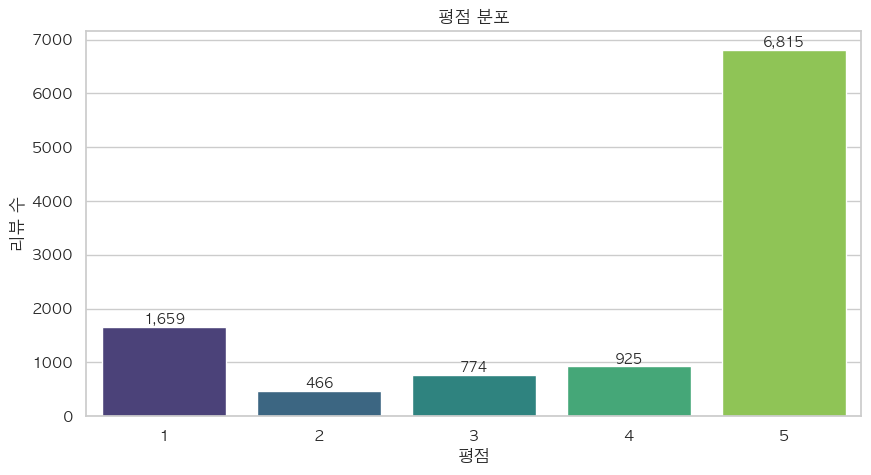

In [5]:
# 평점 분포
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x='rating', data=reviews, palette='viridis', ax=ax)
ax.set_title('평점 분포')
ax.set_xlabel('평점')
ax.set_ylabel('리뷰 수')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)
plt.show()

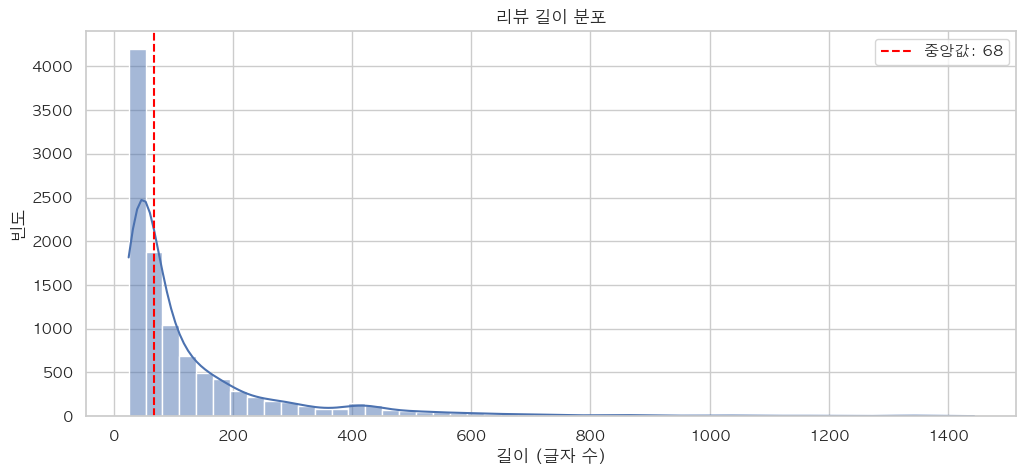

In [6]:
# 리뷰 길이 분포
reviews['review_length'] = reviews['review_text'].fillna('').astype(str).apply(len)

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(reviews['review_length'], bins=50, kde=True, ax=ax)
ax.set_title('리뷰 길이 분포')
ax.set_xlabel('길이 (글자 수)')
ax.set_ylabel('빈도')
ax.axvline(reviews['review_length'].median(), color='red', linestyle='--', label=f'중앙값: {reviews["review_length"].median():.0f}')
ax.legend()
plt.show()

/var/folders/j4/kv6kpgcj0fj1xv3n1l2jmpch0000gn/T/ipykernel_57754/174513226.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='mako', ax=ax)


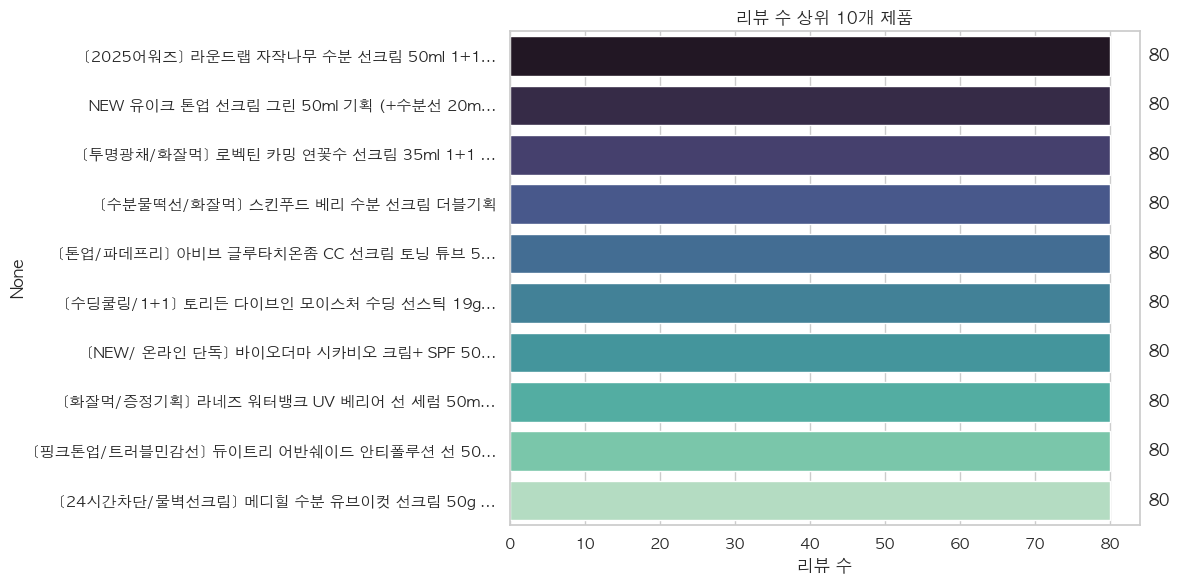

In [7]:
# 상위 10개 제품
top_products = reviews['product_name'].value_counts().head(10)
top_products.index = [x[:35] + '...' if len(str(x)) > 35 else x for x in top_products.index]

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette='mako', ax=ax)
ax.set_title('리뷰 수 상위 10개 제품')
ax.set_xlabel('리뷰 수')
for i, v in enumerate(top_products.values):
    ax.text(v + 5, i, f'{v:,}', va='center')
plt.tight_layout()
plt.show()

---
## 3. LLM 추출 데이터 탐색

LLM을 통해 추출한 Aspect(측면), Polarity(만족/불만족), Context(사용 맥락) 등을 탐색합니다.

In [8]:
# Master Join 데이터 기본 정보
print("=== LLM 분석 데이터 컬럼 ===")
print(master.columns.tolist())
print(f"\n총 {master.shape[0]:,}건의 Aspect-Polarity 쌍")

=== LLM 분석 데이터 컬럼 ===
['review_id', 'goods_no', 'bucket', 'aspect', 'expectation', 'experience', 'polarity', 'context', 'evidence', 'confidence', 'rating', 'rating_bucket', 'season', 'review_month', 'context_tags_str', 'attribute_tags_str', 'skin_tags_str', 'has_conditional', 'golden_nugget', 'is_trial', 'is_low_info', 'text_len_chars', 'helpful_count', 'primary_sort', 'polarity_group']

총 7,471건의 Aspect-Polarity 쌍


/var/folders/j4/kv6kpgcj0fj1xv3n1l2jmpch0000gn/T/ipykernel_57754/4116735074.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aspect_counts.values, y=aspect_counts.index, palette='rocket', ax=ax)


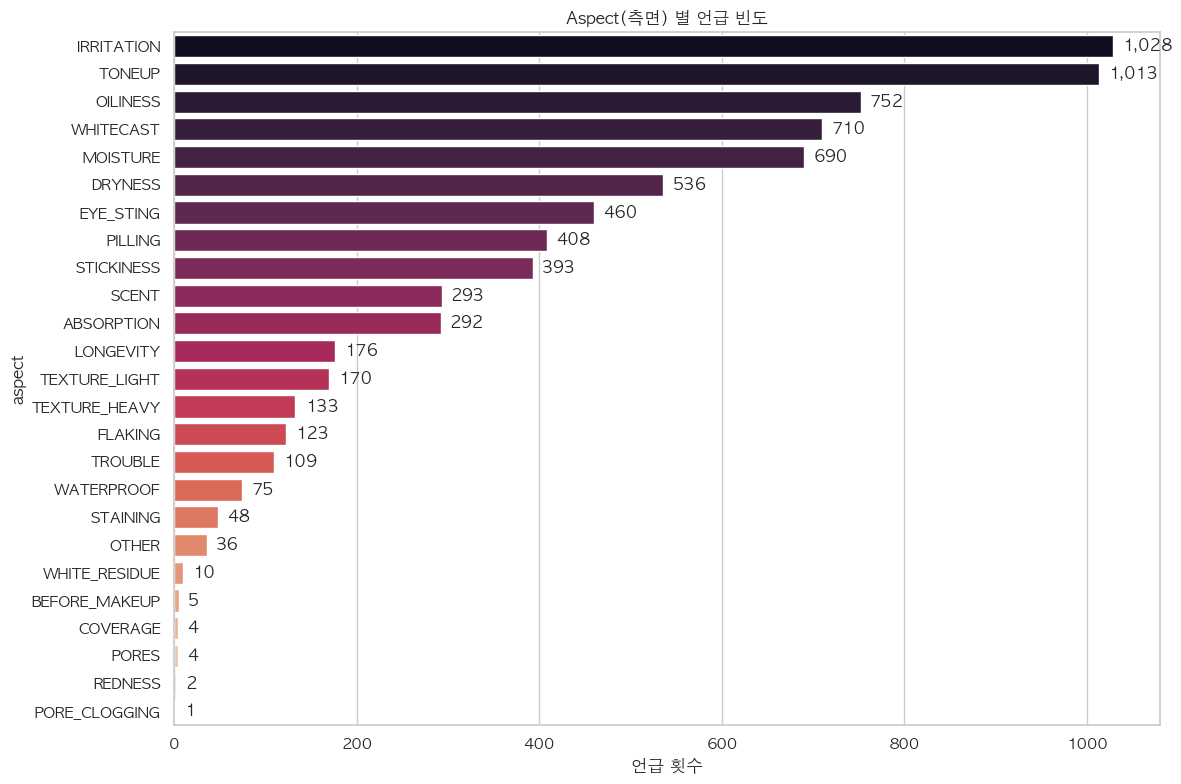

In [9]:
# Aspect 별 빈도
aspect_counts = master['aspect'].value_counts()

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=aspect_counts.values, y=aspect_counts.index, palette='rocket', ax=ax)
ax.set_title('Aspect(측면) 별 언급 빈도')
ax.set_xlabel('언급 횟수')
for i, v in enumerate(aspect_counts.values):
    ax.text(v + 10, i, f'{v:,}', va='center')
plt.tight_layout()
plt.show()

/var/folders/j4/kv6kpgcj0fj1xv3n1l2jmpch0000gn/T/ipykernel_57754/3197473504.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=polarity_counts.index, y=polarity_counts.values,


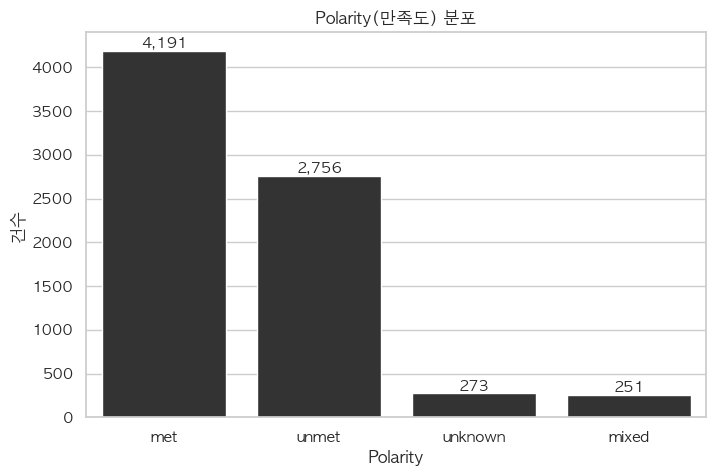

In [10]:
# Polarity 분포
polarity_counts = master['polarity'].value_counts()

fig, ax = plt.subplots(figsize=(8, 5))
colors = {'MET': '#2ecc71', 'UNMET': '#e74c3c', 'MIXED': '#f39c12', 'UNKNOWN': '#95a5a6'}
sns.barplot(x=polarity_counts.index, y=polarity_counts.values, 
            palette=[colors.get(x, '#333') for x in polarity_counts.index], ax=ax)
ax.set_title('Polarity(만족도) 분포')
ax.set_xlabel('Polarity')
ax.set_ylabel('건수')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11)
plt.show()

---
## 4. 리포트 시각화 (분석 결과 탐색)

리포트에서 사용된 주요 분석 결과를 탐색합니다.

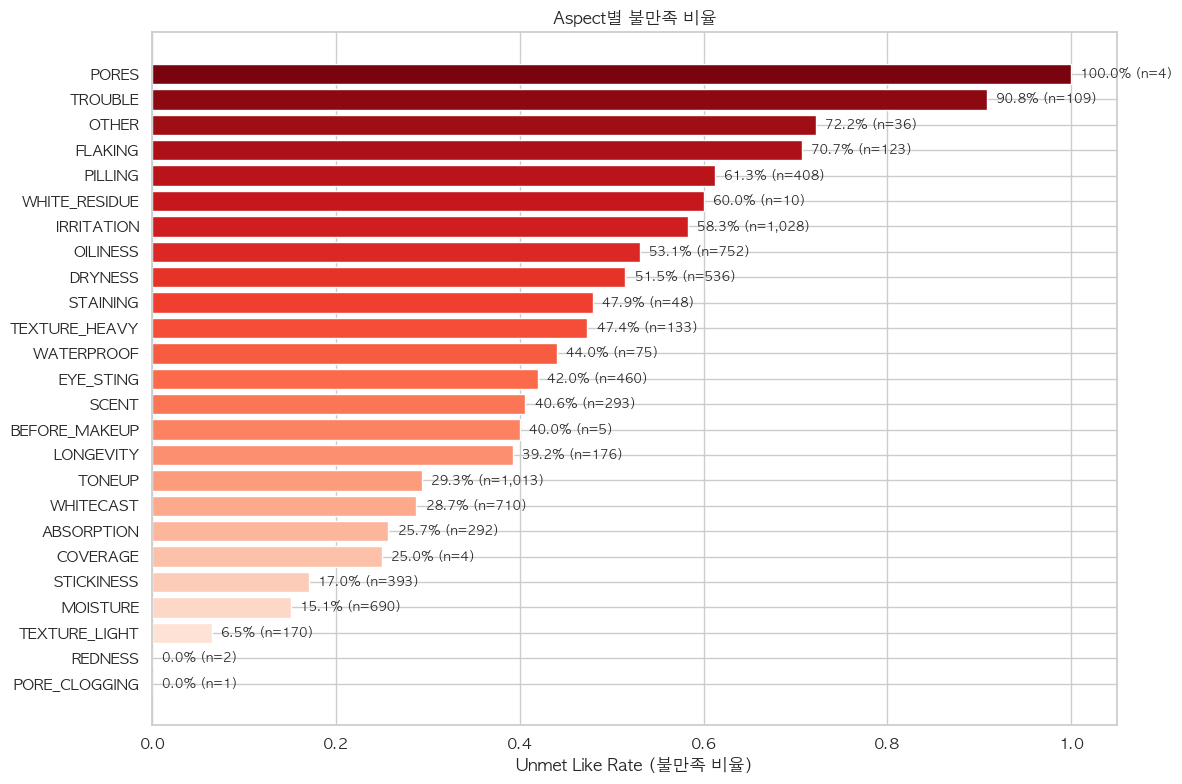

In [11]:
# 전체 Aspect별 Unmet Like Rate (불만족 비율)
polarity_overall_sorted = polarity_overall.sort_values('unmet_like_rate', ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(polarity_overall_sorted['aspect'], polarity_overall_sorted['unmet_like_rate'], 
               color=sns.color_palette('Reds_r', len(polarity_overall_sorted)))
ax.set_xlabel('Unmet Like Rate (불만족 비율)')
ax.set_title('Aspect별 불만족 비율')
ax.invert_yaxis()
for i, (rate, n) in enumerate(zip(polarity_overall_sorted['unmet_like_rate'], polarity_overall_sorted['n_items'])):
    ax.text(rate + 0.01, i, f'{rate:.1%} (n={n:,})', va='center', fontsize=9)
plt.tight_layout()
plt.show()

In [12]:
# Bucket별 분석 (Golden Nugget vs 나머지)
bucket_summary = polarity_bucket.groupby('bucket').agg({
    'n_items': 'sum',
    'met_cnt': 'sum',
    'unmet_cnt': 'sum'
}).reset_index()
bucket_summary['met_rate'] = bucket_summary['met_cnt'] / bucket_summary['n_items']
bucket_summary['unmet_rate'] = bucket_summary['unmet_cnt'] / bucket_summary['n_items']

print("=== Bucket별 요약 ===")
bucket_summary

=== Bucket별 요약 ===


,bucket,n_items,met_cnt,unmet_cnt,met_rate,unmet_rate
0,GOLDEN_NUGGET,3136,2457,406,0.783482,0.129464
1,HELPFUL_LONG,1596,1242,241,0.778195,0.151003
2,LOW_RATING,2382,226,2042,0.094878,0.857263
3,RANDOM_CONTROL,357,266,67,0.745098,0.187675


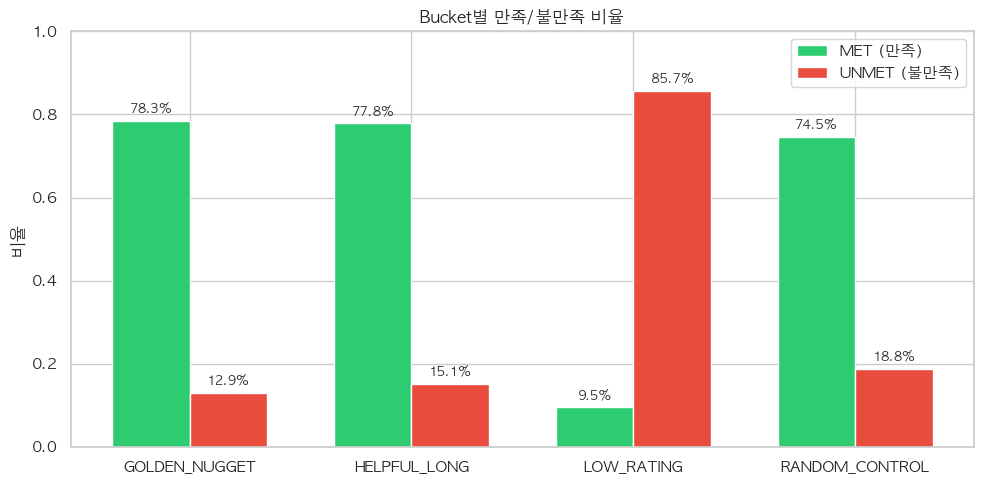

In [13]:
# Bucket별 Unmet Rate 비교
fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(bucket_summary))
width = 0.35
ax.bar([i - width/2 for i in x], bucket_summary['met_rate'], width, label='MET (만족)', color='#2ecc71')
ax.bar([i + width/2 for i in x], bucket_summary['unmet_rate'], width, label='UNMET (불만족)', color='#e74c3c')
ax.set_xticks(x)
ax.set_xticklabels(bucket_summary['bucket'])
ax.set_ylabel('비율')
ax.set_title('Bucket별 만족/불만족 비율')
ax.legend()
ax.set_ylim(0, 1)
for i, (m, u) in enumerate(zip(bucket_summary['met_rate'], bucket_summary['unmet_rate'])):
    ax.text(i - width/2, m + 0.02, f'{m:.1%}', ha='center', fontsize=9)
    ax.text(i + width/2, u + 0.02, f'{u:.1%}', ha='center', fontsize=9)
plt.tight_layout()
plt.show()

In [14]:
# Context별 Unmet 분석
print("=== Context별 Unmet 분석 ===")
context_unmet.head(10)

=== Context별 Unmet 분석 ===


,context_tag,aspect,n_reviews,unmet_like_cnt,met_like_cnt,unmet_like_rate
0,NONE_RULE,IRRITATION,375,287,82,0.765333
1,SUMMER,IRRITATION,417,191,217,0.458034
2,NONE_RULE,OILINESS,224,155,60,0.691964
3,SUMMER,OILINESS,322,140,144,0.434783
4,BEFORE_MAKEUP,PILLING,251,132,117,0.525896
5,BEFORE_MAKEUP,IRRITATION,325,127,193,0.390769
6,BEFORE_MAKEUP,OILINESS,298,121,149,0.406040
7,SUMMER,TONEUP,412,114,294,0.276699
8,SUMMER,DRYNESS,241,104,117,0.431535
9,BEFORE_MAKEUP,TONEUP,440,101,336,0.229545


In [15]:
# Season별 Unmet 분석
print("=== Season별 Unmet 분석 ===")
season_unmet.head(10)

=== Season별 Unmet 분석 ===


,season,aspect,n_reviews,unmet_like_cnt,met_like_cnt,unmet_like_rate
0,fall,ABSORPTION,61,19,42,0.311475
1,fall,BEFORE_MAKEUP,1,0,1,0.000000
2,fall,COVERAGE,1,0,1,0.000000
3,fall,DRYNESS,126,67,50,0.531746
4,fall,EYE_STING,99,36,63,0.363636
5,fall,FLAKING,33,27,5,0.818182
6,fall,IRRITATION,236,160,73,0.677966
7,fall,LONGEVITY,39,15,23,0.384615
8,fall,MOISTURE,130,16,110,0.123077
9,fall,OILINESS,159,90,56,0.566038


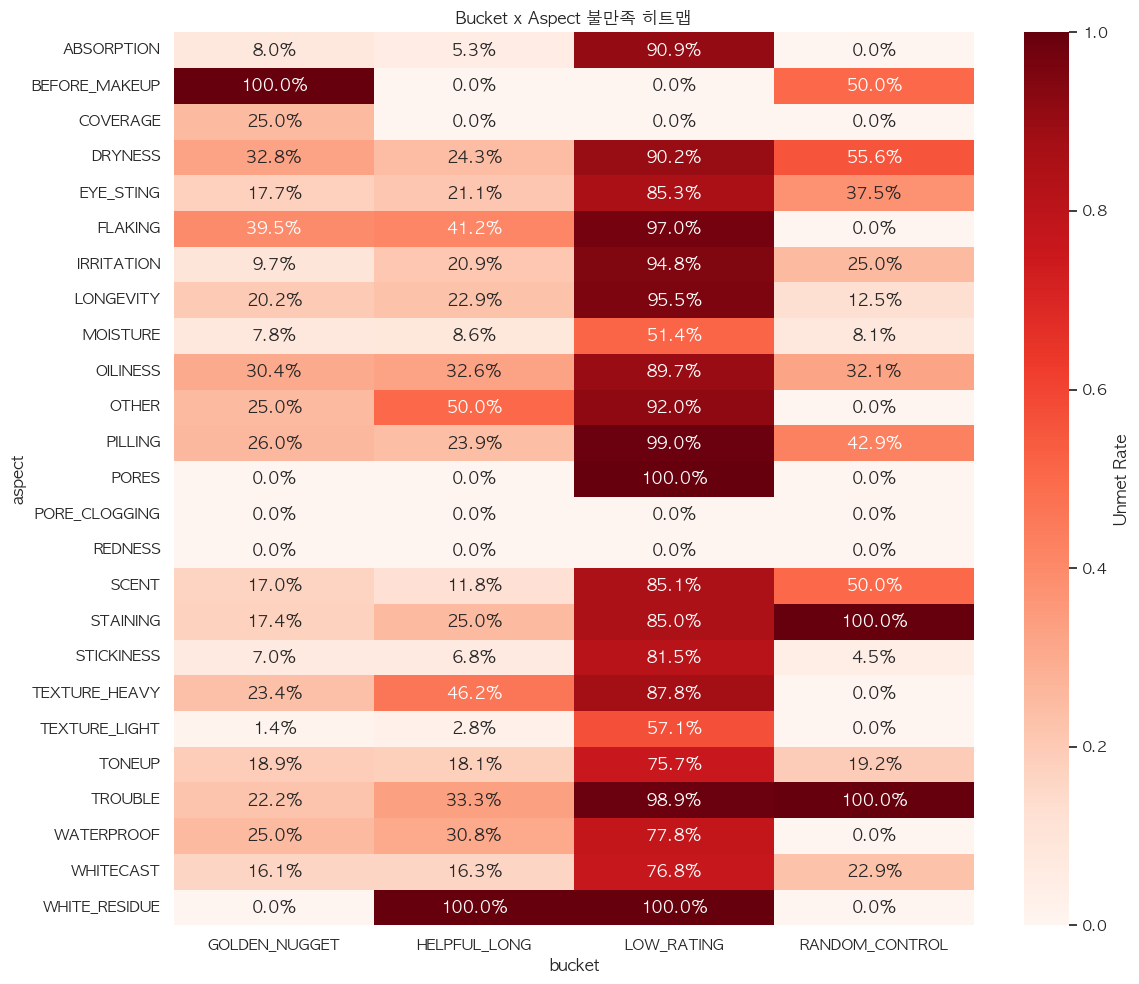

In [16]:
# 히트맵: Bucket x Aspect Unmet Rate
pivot_heatmap = polarity_bucket.pivot_table(
    index='aspect', columns='bucket', values='unmet_like_rate', aggfunc='mean'
).fillna(0)

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pivot_heatmap, annot=True, fmt='.1%', cmap='Reds', ax=ax, cbar_kws={'label': 'Unmet Rate'})
ax.set_title('Bucket x Aspect 불만족 히트맵')
plt.tight_layout()
plt.show()

---
## 5. 샘플 리뷰 확인

조건에 맞는 리뷰 원문을 확인합니다.

In [17]:
# UNMET - PILLING 관련 샘플 리뷰
pilling_unmet = master[(master['aspect'] == 'PILLING') & (master['polarity'] == 'UNMET')]
sample_ids = pilling_unmet['review_id'].head(5).tolist()
sample_reviews = reviews[reviews['review_id'].isin(sample_ids)][['review_id', 'rating', 'review_text']]

print("=== PILLING 불만족 샘플 리뷰 ===")
for _, row in sample_reviews.iterrows():
    print(f"\n[평점 {row['rating']}] {row['review_text'][:200]}...")

=== PILLING 불만족 샘플 리뷰 ===


In [18]:
# Golden Nugget 샘플 (높은 helpful_count)
# master에 이미 helpful_count가 있으므로 직접 사용
golden = master[master['bucket'] == 'GOLDEN_NUGGET'].copy()
golden = golden.sort_values('helpful_count', ascending=False)

# review_text는 reviews에서 가져오기
golden_sample = golden.head(5).merge(
    reviews[['review_id', 'review_text']], 
    on='review_id', 
    how='left'
)

print("=== Golden Nugget 상위 도움됨 샘플 ===")
for _, row in golden_sample.iterrows():
    print(f"\n[도움됨 {row['helpful_count']:.0f}] {row['aspect']} - {row['polarity']}")
    text = row['review_text'] if pd.notna(row['review_text']) else '(텍스트 없음)'
    print(f"{text[:300]}...")

=== Golden Nugget 상위 도움됨 샘플 ===

[도움됨 1800] LONGEVITY - mixed
약한 핑크빛 톤업 선크림인데 촉촉해서 발림성이 좋아요. 톤업 효과는 반톤 업이고 커버력은 없는 편입니다. 토출구가 작아서 양조절에 용이하고 시간 지나도 건조함 없는 점이 만족스러웠습니다. 톤업 지속력은 여름에는 단독 사용하기는 아쉬웠고 요즘은 무난한 것 같아요. 

기획 구성인 폼클렌징도 약산성이라 순한데 세정력 적당하고 미끈거리지 않는 마무리감이라 좋았습니다. 전체적으로 무난무난한 제품입니다....

[도움됨 1800] DRYNESS - met
약한 핑크빛 톤업 선크림인데 촉촉해서 발림성이 좋아요. 톤업 효과는 반톤 업이고 커버력은 없는 편입니다. 토출구가 작아서 양조절에 용이하고 시간 지나도 건조함 없는 점이 만족스러웠습니다. 톤업 지속력은 여름에는 단독 사용하기는 아쉬웠고 요즘은 무난한 것 같아요. 

기획 구성인 폼클렌징도 약산성이라 순한데 세정력 적당하고 미끈거리지 않는 마무리감이라 좋았습니다. 전체적으로 무난무난한 제품입니다....

[도움됨 1800] TONEUP - mixed
약한 핑크빛 톤업 선크림인데 촉촉해서 발림성이 좋아요. 톤업 효과는 반톤 업이고 커버력은 없는 편입니다. 토출구가 작아서 양조절에 용이하고 시간 지나도 건조함 없는 점이 만족스러웠습니다. 톤업 지속력은 여름에는 단독 사용하기는 아쉬웠고 요즘은 무난한 것 같아요. 

기획 구성인 폼클렌징도 약산성이라 순한데 세정력 적당하고 미끈거리지 않는 마무리감이라 좋았습니다. 전체적으로 무난무난한 제품입니다....

[도움됨 1512] LONGEVITY - mixed
✔️건성 추천템

건성인 저희 어머니의 파데프리템으로 재구매!
바르면 광도 예뻐요ㅎㅎ
지성인 저에게는 지속력이 좋지 않아 잘 바르진 않지만,
건성인 어머니는 잘 사용하시더라구요:)...

[도움됨 1350] ABSORPTION - met
수분감 좋은 유기자차 선크림입니다. 넉넉히 발라도 바르고 나면 잔여감 없이 싹 